***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.2 Point Source Assumption (CLEAN)](6_2_clean.ipynb)  
    * Next: [6.4 Residuals and Image Quality](6_4_residuals_and_iqa.ipynb)

***

Import standard modules:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [16]:
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

In [14]:
HTML('../style/code_toggle.html')

***

## 6.3 CLEAN Implementations<a id='deconv:sec:flavours'></a>

In the previous section we introduced the concept of iterative deconvolution using a point-source approximation to the sky, akso known as `CLEAN`. The example is more precisely an image-domain implementation of `CLEAN`. There are in fact multile variants of `CLEAN` as it has been extended over the years to improve results, mainly due to advancements in computing power that have lead to more compute intensive operations being possible. Today there is an active field of developing more advanced `CLEAN` implementation and deconvolution algorithms which can solve special cases. These will be breifly discussed at the end of this section. We will first discuss the implementation and advantages/disadvantages of the basic variants of `CLEAN`: image-domain, gridded visibility-domain, and visibility-domain.

<div class=warn>**To-Do:**</div>

* show dirty image and deconvolved image to setup section content

### 6.3.1 Image-domain (Högbom)

The first implementation of `CLEAN` was presented by [<cite data-cite='1974A&AS...15..417H'>Högbom</cite> &#10548;](http://adsabs.harvard.edu/abs/1974A%26AS...15..417H) in 1974. The basic concept is that the PSF of the observation is known, and source are point-like, so the PSF, multiplied by some flux value, can be iteratively subtracted from the image to remove these point sources. This results in a sky model of $\delta$-functions and a residual image of the noise and sky sources not removed. A psuedo-code implementation of image-domain `CLEAN` is:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, I^{\textrm{res}} \leftarrow I^{D}, i \leftarrow 0$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:}$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

The inputs are the dirty image and the PSF, both of which are 2-d functions in $l$ and $m$, a loop gain parameter $\gamma$, a flux threshold $f_{\textrm{thresh}}$ or maximum number of iterations $N$ as stopping criteria.

#### Input Parameter: Loop gain $(\gamma)$

The $\gamma$ parameter ranges from 0 to 1, and controls the amount of flux subtracted with each iteration. If $\gamma=1$ then all the flux of a pixel is subtracted, this is not good as each pixel contains some amount of noise. If $\gamma=0$ then no flux is subtracted and no deconvolution occurs. Thus, $\gamma$ is set somewhere between 0 and 1, a typical value would be $0.1$, this means that each iteration 10% of the peak flux value is subtracted from the residual image. If the loop gain is too high then the deconvolution maybe over ambitious and subtract out noise from the image, leading to 'holes' in the image. If the loop gain is not large enough then the numbe rof iterations required to complete a deconvolution will be prohibitively long.

#### Input Parameter: Stopping criteria $(N, f_{\textrm{thresh}})$

There are two stopping criteria, only one of which is needed. The first is to set the maximum number of iterations, say $N=100$, then after 100 iteration deconvolution will stop. This has the advantage of setting a fixed computation time. The other criteria is to set a flux threshold $f_{\textrm{thresh}}$ such that when the maximum flux value remaining in the residual image is at or below this threshold deconvolution is stopped. This has the advantage of deconvolving down to a known flux level.


#### Initialization and Output

Deconvolution is initialized by setting the number of iterations to 0, making a copy of the dirty image called the residual image, and creating an empty sky model. During each iteration flux will be subtracted from the residual image and a $\delta$-function source is added to the sky model representing the flux subtracted from the residual image. Onc ethe stopping criteria is met, the completed sky model and residual image is output.

#### Iterative Loop

While the stopping criteria has not been met, a `CLEAN` iteration is done. The location $(l_{\textrm{max}}, m_{\textrm{max}})$ of the pixel with the maximum flux $f_{\textrm{max}}$ in the image is found. The PSF is offset to be centred on the peak flux pixel and multiplied by the flux value and gain loop, this is then subtracted from the residual image. The overall flux of the residual image has been reduced.

$$I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$$

Then a $\delta$-function with flux $\gamma \cdot f_{\textrm{max}}$ source is added to the sky model in the position of the maximum flux.

$$S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$$

The new flux at ($l_{\textrm{max}}, m_{\textrm{max}}$) in the sky model is added to any flux in that position from a previous iteration.

This is the simplest implementation of `CLEAN` but is also limited as one would expect from being the original `CLEAN` method. The first issue is that the residual image and PSF are images with a fixed number of pixels. When subtracting flux from the residual image the PSF is offset, thus flux from only a subset of the residual image is subtracted. This requires either computing a PSF image at least twice as large (in both directions for 4 times the number of pixels), or limiting deconvolution to the centre of the residual image. The second issue is that the sky model is fixed to the resolution of the pixels in the residual image, this leads to artefacts as sources are never perfectly at the centre of a pixel. Accounting for these issues lead to the next developments in `CLEAN`.

### 6.3.2 Gridded Visibility-domain (Clark)

In 1980 [<cite data-cite='1980A&A....89..377C'>Clark</cite> &#10548;](http://adsabs.harvard.edu/abs/1980A%26A....89..377C) introduced a variant on Högbom's method which took advantage of fast Fourier transforms to do a form of 'batch' deconvolution in the the visibility domain after running a partial Högbom deconvolution in the image domain. The general structure of his method was to search for a set of bright pixels in the image domain (above some threshold based on the PSF sidelobes), build a partial sky model in the 'minor' cycle. The partial sky model needs ot be convolved with the PSF before being subtracted from the residual image. Using the Fourier transform and convolution theorem the the sky model and PSF can be Fourier transformed and multiplied together in the visibility domain, and since the Fourier transform is a linear transform, can be subtracted from the gridded visibilities of the residual image. The new residual image is then the Fourier transform of these new residual visibilities. This has the advantage of potentially being faster than Högbom's method, and allows for deconvolution over a larger portion of the image. This implementation in pseudo-code is:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, \ I^{\textrm{res}} \leftarrow I^{D}, \ i \leftarrow 0, \ (\textrm{PSF}_{\textrm{sub}}(l,m), \ R_{\textrm{PSF}}) \leftarrow g(\textrm{PSF}(l,m))$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:} \quad [\textrm{Major Cycle}]$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad S^{\textrm{model}}_{\textrm{partial}} \leftarrow \textrm{Hogbom}(I^{\textrm{res}}, \  \textrm{PSF}_{\textrm{sub}}, \ \gamma, \ f_{\textrm{max}} \cdot R_{\textrm{PSF}}) \quad [\textrm{Minor Cycle}]$

$\qquad V^{\textrm{model}}_{\textrm{partial}} \leftarrow \mathscr{F}\{S^{\textrm{model}}_{\textrm{partial}}\}, V^S \leftarrow \mathscr{F}\{\textrm{PSF}\}, V^{\textrm{res}} \leftarrow \mathscr{F}\{I^{\textrm{res}}\}$

$\qquad V^{\textrm{res}} \leftarrow V^{\textrm{res}} - V^S \cdot V^{\textrm{model}}_{\textrm{partial}}$

$\qquad I^{\textrm{res}}\leftarrow \mathscr{F}^{-1}\{V^{\textrm{res}}\}$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + S^{\textrm{model}}_{\textrm{partial}}$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

The input data and parameters are the same as those for the image-domain `CLEAN`. And, uses Högbom's method as the minor cycle within the major cycle.

#### Initialization

The initialization has an extra step which selects a subset of the PSF to use in the the minor cycle image-domain `CLEAN`.

$$\textrm{PSF}_{\textrm{sub}}(l,m), \ R_{\textrm{PSF}} \leftarrow g(\textrm{PSF}(l,m))$$

The function $g$ which selects this subset is not well defined, and depends on exact implementation of the algorithm. But, generally the subset of the PSF is taken to be the central region of the PSF out to the highest sidelobes (usually the first sidelobes, except in hightly redundant arrays). The function also returns the ratio $R_{\textrm{PSF}}$ of the the highest PSF sidelobe to the PSF main lobe, this will be less than 1. The justification for truncating the PSF is that the majority of the power in the PSF is contained within this region. And, any pixel in the image which is higher than the first sidelobe (as a fraction of the peak pixel flux) contains a source. The trade-off in the size of the PSF subset is that the smaller it is the more of the image can be deconvolved, but at the cost of increased errors. The larger the PSF subset the smaller the image region which can be deconvolved, but the less error-prone the deconvolution.

#### Minor Cycle

The minor cycle is a partial sky model construction using image-domain deconvolution of the current residual image using the subset of the PSF.

$$S^{\textrm{model}}_{\textrm{partial}} \leftarrow \textrm{Hogbom}(I^{\textrm{res}}, \  \textrm{PSF}_{\textrm{sub}}, \ \gamma, \ f_{\textrm{max}} \cdot R_{\textrm{PSF}})$$

The stopping criteria threshold is set to a precentage of the maximum flux based on the PSF sidelobe to main lobe ratio $f_{\textrm{max}} \cdot R_{\textrm{PSF}}$. The larger this ratio the deeper the deconvolution can be done in the minor cycle. As we do not care about the residual image at this point, we ignore this output of Högbom's method.

#### Major Cycle

The major cycle starts as does by finding the paximum flux and position, similar to Högbom's method. A call is then made to Högbom's method using a high flux threshold value, this works as a shallow deconvolution on the pixels with the most flux. The subet of the PSF is used in the minor cycle, this allows for deconvolution across a larger region of the image. From this a partial sky model is returned.

Using the computational efficiency of FFT algorithms the partial sky model, residual image, and full PSF is Fourier transformed to the visibility domain. This produces an ideal sky model visibility $V^{\textrm{model}}_{\textrm{partial}}$, the array sampling function $V^S$, and the residual visibilities $V^{\textrm{res}}$.

$$V^{\textrm{model}}_{\textrm{partial}} \leftarrow \mathscr{F}\{S^{\textrm{model}}_{\textrm{partial}}\} \\ V^S \leftarrow \mathscr{F}\{\textrm{PSF}\} \\ V^{\textrm{res}} \leftarrow \mathscr{F}\{I^{\textrm{res}}\}$$

The sky model visibilities are multiplied by the sampling function (this is the compute intensive convolution of the PSF and sky model in the image-domain) and subtracted from the residual visibilities.

$$\qquad V^{\textrm{res}} \leftarrow V^{\textrm{res}} - V^S \cdot V^{\textrm{model}}_{\textrm{partial}}$$

Finally, the updated residual visibilites are inverse Fourier transformed back to create a new residual image. The full sky model is updated by adding in the sky model components for the minor cycle.

Clark's method of `CLEAN` deconvolution takes advantage of FFT algorithms to speed up the convolution of a partial sky model with the PSF and doing the subtraction in the visibility domain. Using a subset of the PSF to build the image-domain sky model allows for a larger region of the image to be deconvolved, while doing the batch subtraction in the major cycle with the full PSF results in a better (and sometimes faster) deconvolution compared to just doing an image-domain deconvolution with the PSF subset. The limitations are that because the source subtraction is done on gridded visibilities this can result in errors due to the gridding and aliasing effects.

### 6.3.3 Visibility-domain (Cotton-Schwab)

`CLEAN` methods were first implemented in a time of limited computing and memory resources. Careful consideration was required in optimizing these deconvolution methods with in these constraints. This led to good approximate solutions to deconvolution. As computing power and memory has become cheaper more advanced deconvolution methods are continuously in development. These methods are beyond the scope of the course, but are part of an active field of research. See the end of this chapter for [references &#10142;](6_x_further_reading_and_references.ipynb) to current work.

After Clark's method the next major advancement was in 1984, [<cite data-cite='1984AJ.....89.1076S'>Schwab</cite> &#10548;](http://adsabs.harvard.edu/abs/1984AJ.....89.1076S) introduced a modifcation on Clark's method which performs the deconvolution on the ungridded visibilities. Just to be clear, the ungridded visibilities are the visibilities produced during an observation, before they are gridded onto a 2-D plane as descirbed in [$\S$ 5.3](../5_Imaging/5_3_gridding_and_degridding.ipynb). The Cotton-Schwab method allows for deconvolution across the entire image and does not introduce PSF artefact aliasing at the cost of an increase in computation and memory usage. The Cotton-Schwab method is still widely used today and is the basis for most subsequent `CLEAN` implementation.

Just as `CLEAN` is a general term for deconvolution using an iterative sky model subtraction process, the Cotton-Schwab method can vary based on implementation and which additional features are included. As such, it is not possible to write an easy pseudo-code implementation in the abstract. But, at a high level the Cotton-Schwab method follows Clark's major/minor cycle model. But, instead of subtracting the gridded visibilities from the sky model in the major cycle, a method is used to compute the ungridded visibilities for the sky model. There are two methods to generate ungridded visibilities from the sky model:

1. If there are only a few sources in the sky model a direct Fourier transform can be used on each source to compute the exact visibilities for each *uv* sample.
2. When there are meny sources in the sky model, as is usually the case, the sky model is transformed to gridded visibilities as in Clark's methods then a [de-gridder &#10142;](../5_Imaging/5_3_gridding_and_degridding.ipynb) is used to make a close approximation to the ungridded visibilities.

These visibilities based on the sky model, often called *model visibilities*, can be used in the 'self-cal cycle', which is discussed in [$\S$8.3](../8_Calibration/8_2_1GC.ipynb). The model visibilities are subtracted from the observed visibilities resulting in *residual visibilities*. The residual visibilities are then imaged to produce a new residual image and the next iteration of deconovlution can proceed.

Deconvolving with the ungridded visibilities has a number of other advantages to Högbom and Clark's methods:

* There are no PSF aliasing effects because the deconvolution is independent of image size.
* Spatial regions of interest can be separately deconvolved or ignored, allowing for fine control over the sky modelling process.
* The w-term can be accounted for when producing the residual image from the sky model resulting in a more accurate sky model and fewer artefacts in the residual image.

At this point it should be clear that the Cotton-Schwab method (and all its derivative methods) has many advantages over the methods discussed previously in this section, and is the standard `CLEAN` deconvolution method today. It is important to note here that when the discussion of computing limits in deconvolution the gridding/de-gridding process dominates the computational operations and memory budget over all other steps. Complementary to the development of new deconvolution algorithms is the topic of efficient implementation of well developed methods. Högbom and Clark's methods are still used in some cases, such as in simple fields, and are useful to understand as there is a progression from their simplicity to the more complex modern forms of `CLEAN` used today.

### 6.3.4 Deconvolution of a KAT-7 Observation

After this discussion of the various `CLEAN` implementations from an algorithmic point of view it is worthwhile to see how deconvolution looks visually as progressive iterations are performed. Using the KAT-7 observation from the previous chapter, we will step through deconvolution using the Cotton-Schwab `CLEAN` method.

In [64]:
def generalGauss2d(x0, y0, sigmax, sigmay, amp=1., theta=0.):
    """Return a normalized general 2-D Gaussian function
    x0,y0: centre position
    sigmax, sigmay: standard deviation
    amp: amplitude
    theta: rotation angle (deg)"""
    #norm = amp * (1./(2.*np.pi*(sigmax*sigmay))) #normalization factor
    norm = amp
    rtheta = theta * 180. / np.pi #convert to radians
    #general function parameters (https://en.wikipedia.org/wiki/Gaussian_function)
    a = (np.cos(rtheta)**2.)/(2.*(sigmax**2.)) + (np.sin(rtheta)**2.)/(2.*(sigmay**2.))
    b = -1.*(np.sin(2.*rtheta))/(4.*(sigmax**2.)) + (np.sin(2.*rtheta))/(4.*(sigmay**2.))
    c = (np.sin(rtheta)**2.)/(2.*(sigmax**2.)) + (np.cos(rtheta)**2.)/(2.*(sigmay**2.))
    return lambda x,y: norm * np.exp(-1. * (a * ((x - x0)**2.) - 2.*b*(x-x0)*(y-y0) + c * ((y-y0)**2.)))

def plotDeconvModelResidual(niter):
    """Specialized function to plot the results of a deconvolution run,
    convolves the sky model with the restoring beam for visual effect"""
    fig = plt.figure(figsize=(16, 7))
    
    niter = niter
    fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-model.fits'%niter)
    skyModel = fh[0].data
    fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-residual.fits'%niter)
    residualImg = fh[0].data
    
    #get the restoring beam information from the FITS header
    bmin = fh[0].header['BMIN'] #restored beam minor axis (deg)
    bmaj = fh[0].header['BMAJ'] #restored beam major axis (deg)
    bpa = fh[0].header['BPA'] #restored beam angle (deg)
    dRA = fh[0].header['CDELT1'] #pixel size in RA direction (deg)
    ra0 = fh[0].header['CRPIX1'] #centre RA pixel
    dDec = fh[0].header['CDELT2'] #pixel size in Dec direction (deg)
    dec0 = fh[0].header['CRPIX2'] #centre Dec pixel

    #construct 2-D ellipitcal Gaussian function
    gFunc = generalGauss2d(0., 0., bmin/2., bmaj/2., theta=bpa)

    #produce an restored beam image
    imgSize = 2.*(ra0-1) #assumes a square image
    xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float) #make a grid of pixel indicies, recentre
    xpos -= ra0
    ypos -= dec0
    xpos *= dRA #convert pixel number to degrees
    ypos *= dDec #convert pixel number to degrees
    restBeam = gFunc(xpos, ypos) #restored beam image
    
    #convolve beam image with skymodel
    sampFunc = np.fft.fft2(restBeam) #sampling function
    skyModelVis = np.fft.fft2(skyModel[0,0]) #sky model visibilities
    sampModelVis = sampFunc * skyModelVis #sampled sky model visibilities
    convImg = np.abs(np.fft.fftshift(np.fft.ifft2(sampModelVis))) #sky model convolved with restored beam

    gc1 = aplpy.FITSFigure(residualImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
    gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
    gc1.hide_axis_labels()
    gc1.hide_tick_labels()
    plt.title('Residual Image (niter=%i)'%niter)
    gc1.add_colorbar()
    
    #gc2 = aplpy.FITSFigure(skyModel, figure=fig, subplot=[0.5,0.1,0.35,0.8])
    gc2 = aplpy.FITSFigure(convImg, figure=fig, subplot=[0.5,0.1,0.35,0.8])
    gc2.show_colorscale(vmin=0., vmax=2.5, cmap='viridis')
    gc2.hide_axis_labels()
    gc2.hide_tick_labels()
    plt.title('Sky Model')
    gc2.add_colorbar()
    
    fig.canvas.draw()

**TODO**

* what are we starting from? dirty image and blank sky model
* gain thresh setup

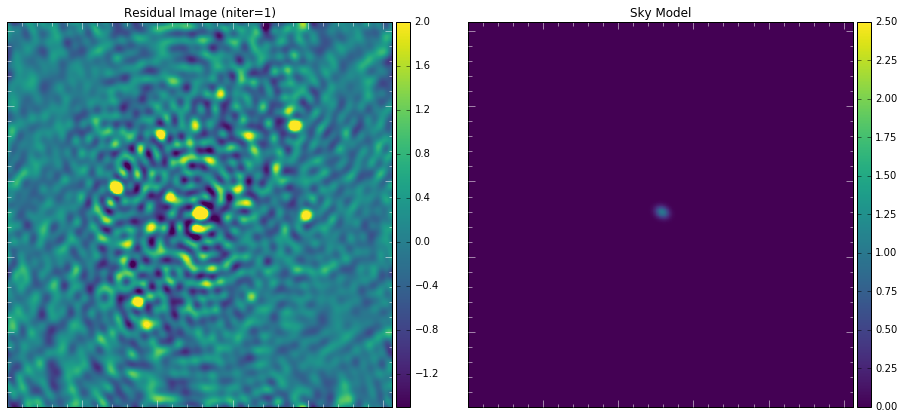

In [71]:
plotDeconvModelResidual(1)

<div class=warn>**To-Do:**</div>

* imager-based 2D set through example
* show the effect in the visibility domain, converts the tracks into a Gaussian distribution, introduce the restoring beam

### 6.3.5 Limits of CLEAN and Modern Deconvolution Developments

<div class=warn>**To-Do:**</div>

* limits of clean: extended sources, large-FOV varying PSF ; current work in compressed sensing and bayesian model selection (don't actually need an image to recover the science)
* extra issues: multi-frequency, multi-scale synthesis, list of current imagers
* lead into residuals and IQA: what makes a good image?
* example: extended source (cygnus? moresane?)

***

Next: [6.4 Residuals and Image Quality](6_4_residuals_and_iqa.ipynb)

<div class=warn>**Future Additions:**</div>

* example: CLEAN implementation limits: hogbom deconvolution region, clark/hogbom aliasing and regions, compare three methods